In [1]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [2]:
%load_ext autoreload
%autoreload 2
import importlib
import math, random, copy, numpy as np
import cProfile
import yaml
from utils import get_class_from_package, HELMConverter
from node import MolSentenceNode
from generator import MCTS

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.
/opt/anaconda3/envs/molgen/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
config_path = "config/mcts_smiles.yaml"
with open(repo_root + config_path) as f:
    conf = yaml.safe_load(f)
    
model_class_name, model_dir, lang_class_name, lang_path = (conf.get(k) for k in ("model_class_name", "model_dir", "lang_class_name", "lang_path"))
lang_class = get_class_from_package("language", lang_class_name)
lang = lang_class.load(repo_root + lang_path)
# if lang_class_name.endswith("HELM"): #TODO: should be removed after .lang inclusion
#     lang.converter = HELMConverter().load(repo_root + "data/helm/library/chembl_35_monomer_library.xml")
model_class = get_class_from_package("transition", model_class_name)
model = model_class(lang=lang, model_dir=repo_root + model_dir)

reward_class_name, reward_conf = (conf.get(k) for k in ("reward_class_name", "reward_conf"))
reward_class = get_class_from_package("reward", reward_class_name)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class_name", "policy_conf"))
policy_class = get_class_from_package("policy", policy_class_path)
policy = policy_class(**policy_conf)

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = get_class_from_package("filter", s.pop("filter_class_name"))
    filters.append(filter_class(**s))

Search is started.
0- time: 0.05, count_rollouts: 2, reward: 0.14123942115844432, node: O=C(NCc1cccc(C(=O)N2CCCC2)c1)N1CCOC1
1- time: 0.11, count_rollouts: 3, reward: 0.35902832966540976, node: N[C@H](c1ccc(C(F)(F)F)cc1)C(=O)Nc1nccc(C(F)(F)F)c1
2- time: 2.78, count_rollouts: 58, reward: 0.3677424560721861, node: S[C@H]1CCCN1C(=O)NCc1nnc(-c2ccccc2)c2ccccc21
3- time: 3.06, count_rollouts: 65, reward: 0.22325570954977245, node: N/C(=O)NCc1ccc(Br)c(Cl)c1
4- time: 3.25, count_rollouts: 69, reward: 0.2507003579045817, node: C[C@@H](NC(=O)N1CCCC1)c1ccc(OC)cc1
5- time: 3.46, count_rollouts: 74, reward: 0.277895500948339, node: Cl[C@@H](c1ccc(F)cc1)N1CN(C(=O)N2CCCC2)CC1
6- time: 4.31, count_rollouts: 94, reward: 0.21769199150554908, node: Cn1cc(NC(=O)C(=O)N2CCC[C@@H](c3ccccc3F)C2)nc1C
7- time: 4.66, count_rollouts: 101, reward: 0.3065834250846157, node: NOc1cc([N+](=O)[O-])cc(-c2ccc(Cl)cc2)c1
8- time: 5.34, count_rollouts: 116, reward: 0.33515822304892584, node: C/C(=C\C#N)NC(=O)Nc1ccc(C(C)(F)F

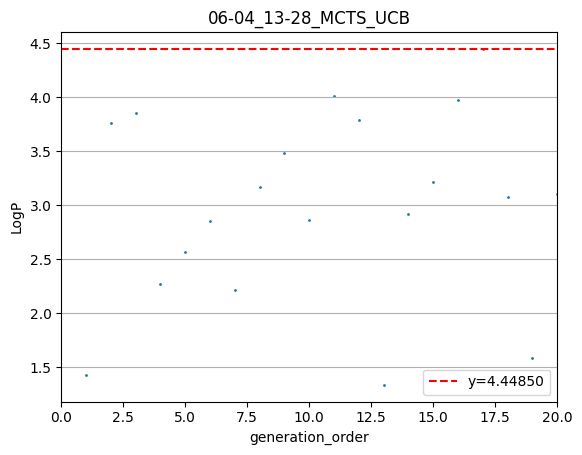

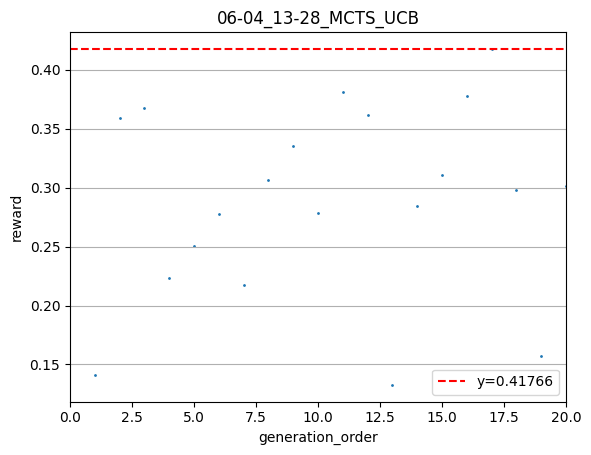

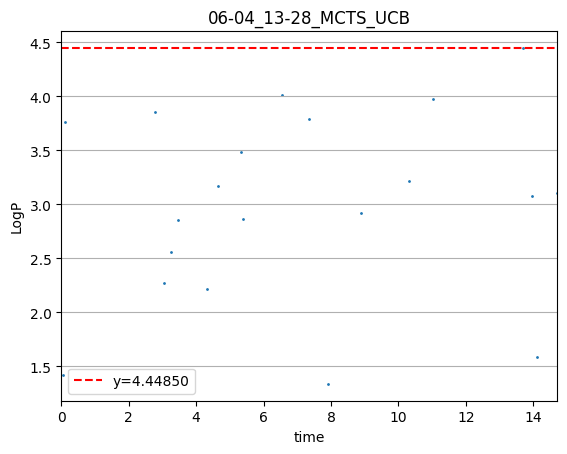

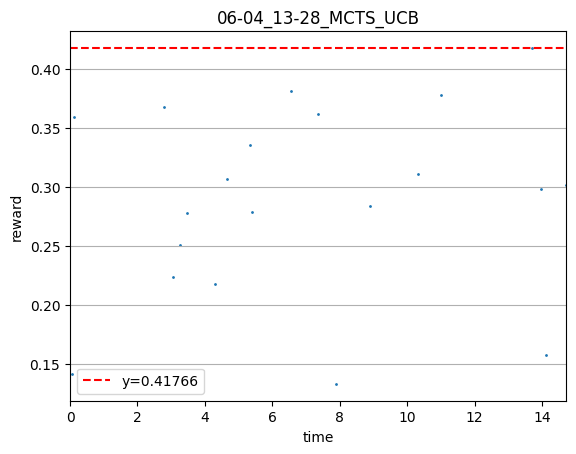

Search is completed.


In [10]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') #invalid mols are already logged

root = MolSentenceNode.bos_node(lang) #TODO: change after root node generalization

output_dir, generation_conf = (conf.get(k) for k in ("output_dir", "generation_conf"))
generator = MCTS(transition=model, reward=reward, policy=policy, filters=filters, output_dir=output_dir)
generator.generate(root=root, **generation_conf)
#cProfile.run("generator.generate(root=root, **generation_conf)"")

In [7]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [ ]:
#load mcts
generator = MCTS.load(save_path, model)